In [ ]:
# import library
import pandas as pd
import numpy as np 
import matlab 
import matplotlib.pyplot as plt
import os
import numpy as np
from gc import callbacks
import scipy.linalg as la
from sklearn import preprocessing
from distfit import distfit
from sklearn.decomposition import PCA
import sys 


In [ ]:
# read the file
# mortality
zipped = True
if zipped:
    mdf_path = r'data/mdf_final.csv'
    mdf = pd.read_csv(mdf_path, low_memory=False)
    mdf = mdf.drop(columns='Unnamed: 0')
    
    pdf_path = r'data\pdf_final.csv'
    pdf = pd.read_csv(pdf_path, low_memory=False)
    pdf = pdf.drop(columns=['Lb', 'Unnamed: 0'])
    
    lnmrdf = pd.read_csv(r'data/lnmr_final.csv', low_memory=False)
    lnmrdf = lnmrdf.drop(columns='Unnamed: 0')
    
    lnfrdf = pd.read_csv(r'data/lnfr_final.csv', low_memory=False)
    lnfrdf = lnfrdf.drop(columns='Unnamed: 0')
    
    
else:
    mortality_path_7 = r'data/MortIcd7.csv'
    mortality_data_7 = pd.read_csv(mortality_path_7, low_memory=False)

    mortality_path_8 = r'data/MortIcd8.csv'
    mortality_data_8 = pd.read_csv(mortality_path_8, low_memory=False)

    mortality_path_9 = r'data/Morticd9.csv'
    mortality_data_9 = pd.read_csv(mortality_path_9, low_memory=False)

    mortality_path_2002 = r'data/Morticd10_part1.csv'
    mortality_data_2002 = pd.read_csv(mortality_path_2002, low_memory=False)

    mortality_path_2007 = r'data/Morticd10_part2.csv'
    mortality_data_2007 = pd.read_csv(mortality_path_2007, low_memory=False)

    mortality_path_2012 = r'data/Morticd10_part3.csv'
    mortality_data_2012 = pd.read_csv(mortality_path_2012, low_memory=False)

    mortality_path_2016 = r'data/Morticd10_part4.csv'
    mortality_data_2016 = pd.read_csv(mortality_path_2016, low_memory=False)

    mdf = pd.concat([mortality_data_7, mortality_data_8, mortality_data_9, mortality_data_2002, mortality_data_2007, mortality_data_2012, mortality_data_2016], ignore_index=True)
    undesired_mortality_columns = ['Admin1', 'SubDiv', 'Sex', 'List', 'Frmat', 'IM_Frmat', 'Cause', 'IM_Deaths1','IM_Deaths2', 'IM_Deaths3', 'IM_Deaths4'] 
    mdf = mdf.drop(columns = undesired_mortality_columns)

    # population
    pop_path = r'data/pop.csv'
    pdf = pd.read_csv(pop_path, low_memory=False)
    dropped = False
    if not dropped:
        undesired_population_columns = ['Admin1', 'SubDiv', 'Sex', 'Frmat', 'Lb'] 
        pdf = pdf.drop(columns = undesired_population_columns)

# country code
country_code_path = r'data/country_codes.csv'
country_code = pd.read_csv(country_code_path, low_memory=False)
# creating the country code map 
country_code_map = {}
for index, rows in country_code.iterrows():
    country_code_map[rows['country']] = rows['name']

In [ ]:
# needs to swap out the nah columns into averages 
done = True
if not done:
    not_used_country_list = []
    country_num_count = 0
    not_useful = False
    for key in country_code_map:
        country_num_count += 1
        display(country_num_count / len(country_code_map))
        country_mdf = mdf[mdf['Country'] == key]
        
        if country_mdf.empty:
            not_used_country_list.append(key)
        
        else:
            min_year = int(country_mdf['Year'].min())
            max_year = int(country_mdf['Year'].max()) 
            for i in range (min_year, max_year + 1):
                
                if not_useful:
                    break
                
                mask = (mdf['Country'] == key) & (mdf['Year'] == i)
                curr_Year = i

                for c in mdf.columns.values:
                    
                    if not_useful:
                        break
                    
                    average = mdf.loc[mask, c].mean()   
                    
                    max_iter = max_year - curr_Year
                    count = 0 
                    while np.isnan(average):
                        curr_Year += 1
                        count += 1
                        mask_alt = (mdf['Country'] == key) & (mdf['Year'] == curr_Year) 
                        average = mdf.loc[mask_alt, c].mean()   
                        
                        if count > max_iter:
                            not_useful = True
                            break 
                        
                        
                    mdf.loc[mask, c] = mdf.loc[mask, c].fillna(average)
                    curr_Year = i 
                    
            if not_useful:
                display(key)
                not_used_country_list.append(key)
                index = mdf[mdf['Country'] == key].index
                mdf = mdf.drop(index)
                not_useful = False
                
    undesired_mortality_columns = ['Admin1', 'SubDiv', 'Sex', 'List', 'Frmat', 'IM_Frmat', 'Cause', 'IM_Deaths1','IM_Deaths2', 'IM_Deaths3', 'IM_Deaths4'] 
    mdf = mdf.drop(columns = undesired_mortality_columns)            
    mdf = mdf.groupby(['Country', 'Year'], as_index=True).agg("sum").reset_index()
    
    # building the potential country list 
    country_list = list(set(mdf['Country']))
    country_list.sort()
    len(country_list) 
        
            

        

In [ ]:
# build pdf
done = True
if not done:
    not_used_pop_list = []
    country_num_count = 0
    not_useful = False
    for key in country_list:
        
            country_num_count += 1
            display(country_num_count / len(country_list))
            
            country_pdf = pdf[pdf['Country'] == key]
            
            if country_pdf.empty:
                not_used_pop_list.append(key)
            
            else:
                min_year = int(country_pdf['Year'].min())
                max_year = int(country_pdf['Year'].max()) 
                
                if min_year == max_year:
                    if (country_pdf.isnull().sum().sum() > 0):
                        not_useful = True
                    else:
                        continue
                
                for i in range (min_year, max_year + 1):
                    
                    if not_useful:
                        break
                    
                    mask = (pdf['Country'] == key) & (pdf['Year'] == i)
                    curr_Year = i

                    for c in pdf.columns.values:
                        
                        if not_useful:
                            break
                        
                        average = pdf.loc[mask, c].mean()   
                        
                        max_iter = max_year - curr_Year
                        count = 0 
                        while np.isnan(average):
                            curr_Year += 1
                            count += 1
                            mask_alt = (pdf['Country'] == key) & (pdf['Year'] == curr_Year)
                            average = pdf.loc[mask_alt, c].mean()   
                            
                            if count > max_iter:
                                not_useful = True
                                break 
                            
                            
                        pdf.loc[mask, c] = pdf.loc[mask, c].fillna(average)
                        curr_Year = i 
                        
                if not_useful:
                    display(key)
                    not_used_pop_list.append(key)
                    index = pdf[pdf['Country'] == key].index
                    pdf = pdf.drop(index)
                    not_useful = False
                    
    # delete the unused countries 
    for key in not_used_pop_list:
        country_list.remove(key)
        
    # finalizing pdf 
    pdf = pdf[pdf['Country'].isin(country_list)]
    pdf = pdf.groupby(['Country', 'Year'], as_index=True).agg("sum").reset_index()
    pdf.to_csv(r'data/pdf_final.csv')
    
    # finalizing mdf 
    mdf = mdf[mdf['Country'].isin(country_list)]
    mdf.to_csv(r'data/mdf_final.csv')
                    
                
        
    

In [ ]:
# create the log mortality rate graph 

done = True
if not done:
    
    lnmr_dict = {}
    lnmr_dict['Country'] = []
    lnmr_dict['Year'] = []
    for i in range (6, 27):
        lnmr_column = f'Log Mortality{i}'
        lnmr_dict[lnmr_column] = []
    
    lnmrdf = pd.DataFrame(lnmr_dict)
    
    country_list = list(set(mdf['Country']))
    country_list.sort()
    
    country_num_count = 0
    for key in country_list:
        
        country_num_count += 1
        display(country_num_count / len(country_list))
        
        country_mdf = mdf[mdf['Country'] == key]
        min_year = int(country_mdf['Year'].min())
        max_year = int(country_mdf['Year'].max()) 
        
        for i in range (min_year, max_year + 1):
            
            m_mask = (mdf['Country'] == key) & (mdf['Year'] == i)
            p_mask = (pdf['Country'] == key) & (pdf['Year'] == i)
            
            if pdf[p_mask].empty or mdf[m_mask].empty:
                continue
            else:
                lnmrdf.loc[lnmrdf.shape[0]] = ['None'] * lnmrdf.shape[1]
                lnmrdf.loc[lnmrdf.shape[0]-1, ['Country']] = key
                lnmrdf.loc[lnmrdf.shape[0]-1, ['Year']] = i
            
            for c in range(6, 27):
                
                if c == 6:
                    deaths = 0
                    population = 0
                    for j in range (2, 7):
                        m_column = f'Deaths{c}'
                        p_column = f'Pop{c}'
                        lnmr_column = f'Log Mortality{c}'
                        try:
                            deaths += mdf[m_mask][m_column].values.astype('float')[0]
                            population += pdf[p_mask][p_column].values.astype('float')[0]
                        except:
                            display(key)
                            display(i)
                            display(c)
                            callbacks()
                else:
                    m_column = f'Deaths{c}'
                    p_column = f'Pop{c}'
                    lnmr_column = f'Log Mortality{c}'
                    try:
                        deaths = mdf[m_mask][m_column].values.astype('float')[0]
                        population = pdf[p_mask][p_column].values.astype('float')[0]
                    except:
                        display(key)
                        display(i)
                        display(c)
                        callbacks()
                try:
                    ratio = deaths / population
                    lnmrdf.loc[lnmrdf.shape[0]-1, lnmr_column] = np.log(ratio)
                except:
                    display(key)
                    display(i)
                    display(c)
                    callbacks()
    
    lnmrdf.to_csv(r'data/lnmr_final.csv')

In [ ]:
# fit the mortality model 
from numpy import inf


done = False
pred_year = 2050
each_country_num = 300
if not done:
    
    country_list = list(set(lnmrdf['Country']))
    country_list.sort()
    mort_d = {}
    
    for key in country_list:
        
        try: 
        
            display(key)
            c_s = []
            
            country_lnmrdf = lnmrdf[lnmrdf['Country'] == key]
            min_year = int(country_lnmrdf['Year'].min())
            max_year = int(country_lnmrdf['Year'].max())
            
            ma = country_lnmrdf[country_lnmrdf['Year'] > min_year].drop(columns=['Country', 'Year']).values
            mb = country_lnmrdf[country_lnmrdf['Year'] < max_year].drop(columns=['Country', 'Year']).values

            m = np.nan_to_num(ma - mb)
            scaler = preprocessing.StandardScaler().fit(m)
            m_scaled = np.nan_to_num(scaler.transform(m))
            u, singular, V_transpose = np.linalg.svd(m_scaled)
            singular[singular == inf] = sys.float_info.max
            dist = distfit()
            # gamma distribution 
            dist.fit_transform(singular)
            # loading vectors
            pca = PCA(n_components=1)
            transformed_data = pca.fit(m_scaled).transform(m_scaled)
            eigenValues = pca.explained_variance_ratio_
            # loading = pca.components_.T * np.sqrt(pca.explained_variance_)
            loadings = pd.DataFrame(pca.components_.T)
            lv = np.matrix(loadings[0].values)
            y = int((pred_year - max_year)) 
            for i in range (each_country_num):    
                m_new = np.matrix(dist.generate(y)).reshape(y, 1)
                pred = m_new * lv
                c_s.append(pred)
                
            mort_d[key] = c_s
        
        except:
            continue

In [ ]:
# construct log fertility graph 
done = True
if not done:
    
    lnfr_dict = {}
    lnfr_dict['Country'] = []
    lnfr_dict['Year'] = []
    lnfr_dict['Log Fertility'] = []
    
    lnfrdf = pd.DataFrame(lnfr_dict)

    for key in mort_d:
        
        country_pdf = pdf[pdf['Country'] == key]
        country_mdf = mdf[(mdf['Country'] == key)]
        country_mdf = country_mdf[(country_mdf['Year'].isin(country_pdf['Year']))]
        min_year = np.max([int(country_mdf['Year'].min()), int(country_pdf['Year'].min())])
        max_year = np.min([int(country_mdf['Year'].max()), int(country_pdf['Year'].max())])

        for year in range(min_year, max_year):
            
            try:
            
                lnfrdf.loc[lnfrdf.shape[0]] = ['None'] * lnfrdf.shape[1]
                lnfrdf.loc[lnfrdf.shape[0]-1, ['Country']] = key
                lnfrdf.loc[lnfrdf.shape[0]-1, ['Year']] = year
                a = country_pdf[country_pdf['Year'] == year+1]['Pop1'].values[0]
                b = country_pdf[country_pdf['Year'] == year]['Pop1'].values[0]
                d = country_mdf[country_mdf['Year'] == year + 1]['Deaths1'].values[0]
                yp = (a - b + d) / b 
                lnfrdf.loc[lnfrdf.shape[0]-1, 'Log Fertility'] = np.log(yp)
            
            except:
                continue
    
    lnfrdf.to_csv(r'data/lnfr_final.csv')
    

In [ ]:
# fit the fertility model 
done = False
if not done:
    country_list = list(set(lnfrdf['Country']))
    country_list.sort()
    fert_d = {}
    
    for key in country_list:
        display(key)
        c_s = []
        country_lnmrdf = lnmrdf[lnmrdf['Country'] == key]
        max_year = int(country_lnmrdf['Year'].max())
        p = np.nan_to_num(lnfrdf[lnfrdf['Country'] == key]['Log Fertility'].values)
        cp = p[1:] - p[:-1]
        dist = distfit()
        # gamma distribution 
        dist.fit_transform(cp)
        
        
        y = int((pred_year - max_year))
        
        for i in range (each_country_num):    
            pred = np.matrix(dist.generate(y)).reshape(y, 1)
            c_s.append(pred)
        
    
        fert_d[key] = c_s
        
        
    

In [ ]:
# construct the final graph
done = False
first = True
if not done:
    
    for key in mort_d:
        country_mdf = mdf[mdf['Country'] == key]
        country_pdf = pdf[pdf['Country'] == key]
        country_lnmrdf = lnmrdf[lnmrdf['Country'] == key]
        country_lnfrdf = lnfrdf[lnfrdf['Country'] == key]
        
        max_year = int(country_lnmrdf['Year'].max())
        
        country_pdf.plot(kind='scatter',x='Year',y='Pop1',color='red')    
        
        year_range = int((pred_year - max_year) / 5)
        for i in mort_d[key]:
            for j in fert_d[key]:
                max_lnmrdf_row = country_lnmrdf[country_lnmrdf['Year'] == max_year].values
                max_lnfrdf_row = country_lnfrdf[country_lnfrdf['Year'] == max_year].values
                max_pdf_row = country_pdf[country_pdf['Year'] == max_year]
                for year in range (1, year_range+1):
                    curr_Year = max_year + year * 5
                    next_lnmrdf = i[year-1]
                    next_lnfrdf = j[year-1]
                    
                    max_lnmrdf_row += next_lnmrdf
                    actually_mr = np.diagonal(np.exp(max_lnmrdf_row)) 
                    
                    max_lnfrdf_row += next_lnfrdf
                    actually_fr = np.exp(max_lnfrdf_row)
                    
                    population_array = []
                
                    for c in range(6, 27):
                
                        if c == 6:
                            if first:
                                population = 0
                                for j in range (2, 7):
                                    p_column = f'Pop{c}'
                                    try:
                                        population += max_pdf_row[p_column].values.astype('float')[0]
                                    except:
                                        display(key)
                                        display(i)
                                        display(c)
                                        callbacks()
                                population_array.append(population)
                            else:
                                p_column = f'Pop{c}'  
                                try:
                                    population = max_pdf_row[p_column].values.astype('float')[0]
                                except:
                                    display(key)
                                    display(i)
                                    display(c)
                                    callbacks()
                        else:
                            p_column = f'Pop{c}'  
                            try:
                                population = max_pdf_row[p_column].values.astype('float')[0]
                            except:
                                display(key)
                                display(i)
                                display(c)
                                callbacks()

                            population_array.append(population)
                            
                    population_array = np.array(population_array)
                    num = population_array.shape[0]
                    population_array.reshape(1, num)
                    total_pop = max_pdf_row['Pop1'].values[0]
                    deaths = population_array * actually_mr * 5
                    population_array -= deaths
                    total_deaths = deaths.sum()
                    births = total_pop * actually_fr * 5
                    

                        
                        
                    y = total_pop - total_deaths + births
                    plt.scatter(curr_Year, y, color='blue')
                    
                    next_dict = {
                        'Pop1': y
                    }
                    
                    for c in range (6, 27):
                        if c == 6:
                            p_column = f'Pop{c}'  
                            next_dict[p_column] = y
                        elif c == 27:
                            break
                        else:
                            p_column = f'Pop{c}'  
                            next_dict[p_column] = population_array[c - 7]
                            
                    max_pdf_row = pd.DataFrame(next_dict)
        
        
        path = f'{key}.png'
        plt.savefig(path)
                    
                    
                    
                    
                    
                                        
                    
        

In [ ]:
# is_outlier(points, thresh=3.5)
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

[1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024,
 2025,
 2026,
 2027,
 2028,
 2029,
 2030,
 2031,
 2032,
 2033,
 2034,
 2035,
 2036,
 2037,
 2038,
 2039,
 2040,
 2041,
 2042,
 2043,
 2044,
 2045,
 2046,
 2047,
 2048,
 2049,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024,
 2025,
 2026,
 2027,
 2028,
 2029,
 2030,
 2031,
 2032,
 2033,
 2034,
 2035,
 2036,
 2037,
 2038,
 2039,
 2040,
 2041,
 2042,
 2043,
 2044,
 2045,
 2046,
 2047,
 2048,
 2049,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024,
 2025,
 2026,
 2027,

[3728699.3406957365,
 3862540.1898633013,
 3897570.293086273,
 3982980.3990803887,
 4038444.9591050553,
 4119275.501631423,
 4193696.282360157,
 4197151.021143215,
 3927830.4098868254,
 3524020.039706074,
 3258202.804802882,
 3135369.221646933,
 2844245.885498095,
 2417594.1076292014,
 1971847.1485843025,
 1064161.9704319313,
 808778.453012731,
 599740.6084264921,
 436575.2249582957,
 341755.1881770667,
 206765.87792818114,
 178629.56217926703,
 85444.59387978652,
 88474.6422219247,
 29118.81269847247,
 83180.87211129007,
 9995.529088462074,
 9964.334374065222,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3775316.4577155295,
 3960303.8414235446,
 4015002.6933403932,
 4039391.629480136,
 4023068.3331129192,
 3985313.5344386795,
 3767987.9310580897,
 3518622.478459144,
 2948671.65654039,
 2304355.156025223,
 1844696.4274136133,
 1640137.9005530577,
 1367003.4538663598,
 1

AxisError: axis 0 is out of bounds for array of dimension 0

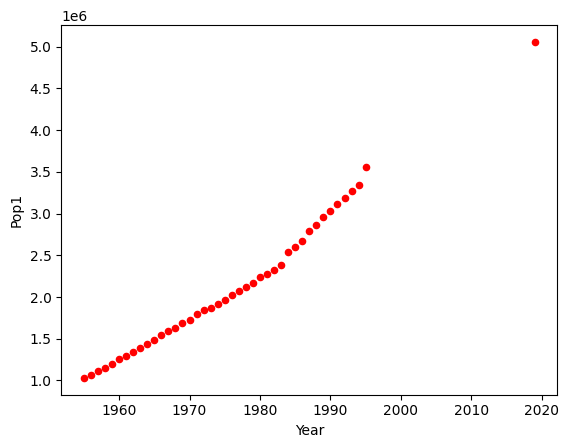

In [29]:
key = 2140
country_mdf = mdf[mdf['Country'] == key]
country_pdf = pdf[pdf['Country'] == key]
country_lnmrdf = lnmrdf[lnmrdf['Country'] == key]
country_lnfrdf = lnfrdf[lnfrdf['Country'] == key]
        
max_year = np.min([(country_lnmrdf['Year'].max(), country_lnfrdf['Year'].max(), country_pdf['Year'].max())])
country_pdf.plot(kind='scatter',x='Year',y='Pop1',color='red')    
        
year_range = int((pred_year - max_year))
curr_Year_array = []
total_pop_array = []
for i in mort_d[key]:
    for j in fert_d[key]:
        
        max_lnmrdf_row = country_lnmrdf[country_lnmrdf['Year'] == max_year].drop(columns=['Country', 'Year']).values
        max_lnfrdf_row = country_lnfrdf[country_lnfrdf['Year'] == max_year].drop(columns=['Country', 'Year']).values
        max_pdf_row = country_pdf[country_pdf['Year'] == max_year].drop(columns=['Country', 'Year', 'Pop1']).values[0]
        curr_Year = max_year
        population_array = []
        population_array.append(max_pdf_row[:5].sum())
        
        for ele in max_pdf_row[5:]:
            population_array.append(ele)
        
        population_array = np.array(population_array)
        
        for year in range (0, year_range-1):
            
            next_lnmrdf = i[year]
            next_lnfrdf = j[year]
            
            max_lnmrdf_row += next_lnmrdf
            actually_mr = np.diag(np.exp(max_lnmrdf_row)[0]) 
            max_lnfrdf_row += next_lnfrdf
            actually_fr = np.exp(max_lnfrdf_row)[0][0]

            total_pop = population_array.sum()
    
            deaths = population_array * actually_mr
            deaths = np.nan_to_num(deaths.diagonal()) 
            total_deaths = deaths.sum() 
            
            births = total_pop * actually_fr
            
            population_array[0] += births
            population_array -= deaths
            
            for ele in range(len(population_array)):
                if population_array[ele] < 0:
                    population_array[ele] = 0
            
            aged = population_array / 5
            population_array -= aged
            
            for ele in range (len(aged)-1):
                population_array[ele+1] += aged[ele]
            
            total_pop = population_array.sum()
            curr_Year += 1
            
            
            curr_Year_array.append(curr_Year)
            total_pop_array.append(total_pop)
            
            # plt.scatter(curr_Year, total_pop, color='blue')
            
    
        
    break

display(curr_Year_array)
display(total_pop_array)

remove_index = []
for i in range (len(total_pop_array)):
    if is_outlier(total_pop_array[i]):
        remove_index.append(i)
total_pop_array = np.array(total_pop_array)
curr_Year_array = np.array(curr_Year_array)
fixed_total_pop_array = np.delete(total_pop_array, remove_index)
fixed_curr_Year_array = np.delete(curr_Year_array, remove_index)

plt.scatter(fixed_curr_Year_array, fixed_total_pop_array, color='blue')